In [1]:
import hybridmodules as hy
import sys
import numpy as np
import h5py
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy as sci
import lal
from pycbc import pnutils
import hashlib
import pycbc
from pycbc.types import TimeSeries
from pycbc.waveform import utils as wfutils
from pycbc.waveform import get_td_waveform,td_approximants,get_fd_waveform,fd_approximants
from pycbc import pnutils
import scipy
#sys.path.insert(0,"/home/ericflynn/src")
import romspline

In [ ]:
print td_approximants()

In [ ]:
### selected hybridmodules.py functions that are used 
def rhOverM_to_SI(polarization,total_mass):
        solar_mass_mpc = 1.0/(1.0e6 * lal.PC_SI/lal.MRSUN_SI)
        h_conversion = total_mass*solar_mass_mpc
        return polarization*h_conversion

def tOverM_to_SI(times,total_mass):
        t_conversion = total_mass*lal.MTSUN_SI
        return times*t_conversion

def SI_to_rhOverM(polarization,total_mass):
        solar_mass_mpc = lal.MRSUN_SI/(1e6*lal.PC_SI)
        h_conversion = solar_mass_mpc/total_mass
        return polarization*h_conversion

def SI_to_rOverM(times,total_mass):
        t_conversion = total_mass*lal.MTSUN_SI
        return times/t_conversion
    
def m_phase_from_polarizations(hp,hc,remove_start_phase=True):
        p_wrapped = np.arctan2(hp,hc)
        p = np.unwrap(p_wrapped)
        if remove_start_phase:
                p += -p[0]
        return np.abs(p)
def m_frequency_from_polarizations(hp,hc,delta_t):
        phase = m_phase_from_polarizations(hp,hc)
        freq = np.diff(phase)/(2.0*np.pi*delta_t)
        return freq
def hybridize(h1,h1_ts,h2,h2_ts,match_i,match_f,delta_t=1/4096.0,M=200,info=0):
        h2_seg = h2[match_i:match_f]
        z = sci.signal.fftconvolve(h1,np.conj(h2_seg[::-1]))
        abs_z = np.abs(z)
        w = np.argmax(abs_z) - len(h2_seg) + 1
        delta_w = w + len(h2_seg)
        h2_norm = np.linalg.norm(h2_seg)
        h1_norm = np.linalg.norm(h1[w:delta_w])
        norm_z = abs_z/(h1_norm*h2_norm)
        phi = np.angle(z[np.argmax(abs_z)])
        h2_phase_shift = np.exp(1j*phi)*h2
        shift_time  = (w - match_i)*delta_t
        h2_tc = h2_ts - h2_ts[0] + shift_time
        off_len = (M-1)/2 + 1
        on_len = (M+1)/2
        window = sci.signal.hann(M)
        ##Initialize off and on arrays
        off_hp = np.zeros(off_len)
        on_hp = np.zeros(on_len)
        off_hc = np.zeros(off_len)
        on_hc = np.zeros(on_len)
        ##Bounds for windowing functions
        lb= w
        mid=off_len + w
        ub = M-1 + w
        ##multiply each off and on section by appropriate window section
        for i in range(on_len):
                on_hp[i] = np.real(h2_phase_shift[match_i+i])*window[i]
        for i in range(off_len):
                off_hp[i] = np.real(h1[w+i])*window[i+off_len-1]
        for i in range(on_len):
                on_hc[i] = np.imag(h2_phase_shift[match_i+i])*window[i]
        for i in range(off_len):
                off_hc[i] = np.imag(h1[w+i]*window[i+off_len-1])
         ##Next add the on and off sections together
        mix_hp = on_hp + off_hp
        mix_hc = on_hc + off_hc
        h1_hp_split = np.real(h1[:w])
        h1_hc_split = np.imag(h1[:w])
        h1_ts_split = h1_ts[:w]
        hybrid_t = np.concatenate((np.real(h1_ts_split),np.real(h2_tc[match_i:])), axis =0)
        hybrid_hp = np.concatenate((h1_hp_split,mix_hp,np.real(h2_phase_shift[match_i+off_len:])),axis = 0)
        hybrid_hc = np.concatenate((h1_hc_split,mix_hc,np.imag(h2_phase_shift[match_i+off_len:])),axis =0)
        hybrid = (hybrid_t, hybrid_hp, hybrid_hc)
        freq = m_frequency_from_polarizations(hybrid_hp,hybrid_hc,delta_t=delta_t)
        hh_freq = freq[w]
        if info == 0:
                return hybrid
        if info == 1:
                return(np.max(norm_z),w,phi,h2_phase_shift,h2_tc,hybrid,h2_tc[0],hh_freq)
        else:
                return 'use info = 0 or 1'

In [9]:
sample_rate = 4096*8
delta_t = 1.0/sample_rate
Sph_Harm = 0.6307831305 ### 2-2 spherical harmonic. We are only concerned about the 2-2 here.
solar_mass_mpc = lal.MRSUN_SI / (1e6*lal.PC_SI)

In [6]:
### path to simulation
sim_name = '../Simulations/BNS/Haas/Haas_Reformat_rh_CceR2090_l2_m2.h5'

In [7]:
### First read in h5 file
#### get numerical parameters. For BH_NS or BNS, if tidal coeff. are not included, use lalsim_get_ns_params
#### Note: sometimes when the spins are small Pycbc returns an error. If that happens just set spins to 0.0 manually.
num = h5py.File(sim_name, 'r')
#for item in num.attrs.keys():
#    print item + ":", num.attrs[item]
### m1,m2 are typically grav_mass, ADM mass, or Baryon mass
m1 = num.attrs['ADM_mass1']
m2 = num.attrs['ADM_mass2']
total_mass = m1+m2
s1x = num.attrs['spin1x']
s1y = num.attrs['spin1y']
s1z = num.attrs['spin1z']
s2x = num.attrs['spin2x']
s2y = num.attrs['spin2y']
s2z = num.attrs['spin2z']
LNhatx = num.attrs['LNhatx']
LNhaty = num.attrs['LNhaty']
LNhatz = num.attrs['LNhatz']
n_hatx = num.attrs['nhatx']
n_haty = num.attrs['nhaty']
n_hatz = num.attrs['nhatx']
lambda_1 = num.attrs['lambda1']
lambda_2 = num.attrs['lambda2']
distance = 52.25 ## observer distance in Mpc
inclination = 0.0
f_lower_num = num.attrs['f_lower_at_1MSUN']/(2.0 * lal.TWOPI * total_mass_import * lal.MTSUN_SI)
num.close()

type: Hybrid:<type 'type'>
����=�K
sim_name: Haas
Format: 1
Lmax: 2
f_lower_at_1MSUN: 0.0270013128495
eta: 0.25
spin1x: 0.0
spin1y: 0.0
spin1z: 0.0
spin2x: 0.0
spin2y: 0.0
spin2z: 0.0
LNhatx: 0.0
LNhaty: 0.0
LNhatz: 1.0
nhatx: 0.0
nhaty: 1.0
nhatz: 0.0
ADM_mass1: 1.64
ADM_mass2: 1.64
Baryon_mass1: 1.779
Baryon_mass2: 1.779
lambda1: 413.908
lambda2: 413.908
3.28
133.0


/share/apps/pycbc170902/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


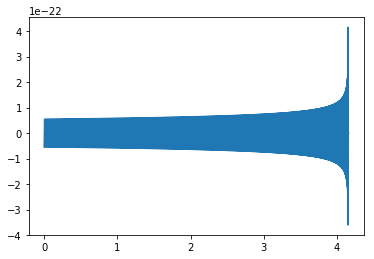

In [7]:
f_low_PN = 80
approx = 'TEOBv2'
###hy.getPN is just a condensed version of get_td_waveform() with a timeshift and conversion to numpy arrays. 
### see hybridmodules.py for more detail
PN_model = hy.getPN(approx,m1=m1,m2=m2,f_low=f_low_PN,distance=distance,delta_t=delta_t,
               sAx=s1x,sAy=s1y,sAz=s1z,sBx=s2x,sBy=s2y,sBz=s2z,inclination=inclination,tidal1=lambda_1,tidal2=lambda_2)
plt.plot(PN_model[0],PN_model[1])
plt.show()

In [10]:
h2p,h2c = get_td_waveform(approximant='NR_hdf5',numrel_data=sim_name,mass1=m1,
                                                                      mass2=m2,
                                                                      spin1z=s1z,spin1x=s1x,spin1y=s1y,
                                                                      spin2z=s2z,spin2x=s2x,spin2y=s2y,
                                                                      tidal1=lambda_1,tidal2=lambda_2,
                                                                      delta_t=delta_t,distance=distance,
                                                                      f_lower=f_lower_num,
                                                                      inclination=inclination)


In [11]:
h1 = PN_model[1] ### time array
h1_tc = PN_model[0] ### In hp + j*hc form
h2 = np.array(h2p + 1j*h2c)
h2t = np.array(h2p.sample_times)
h2_tc = h2t - h2t[0] ### shift times so h2 starts at  t=0


/share/apps/pycbc170902/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


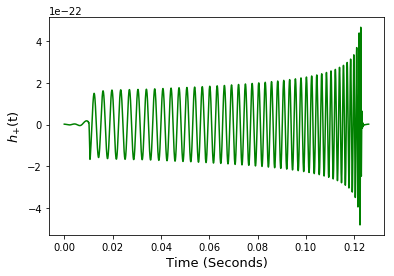

In [12]:
plt.plot(h2_tc,np.real(h2),color='green')
plt.xlabel('Time (Seconds)',fontsize=13)
plt.ylabel('$h_{\plus}$(t)',fontsize=13)
plt.show()

In [ ]:
plt.plot(h2_tc,np.real(h2))
plt.show()

In [11]:
### this returns an array of the form (np.max(norm_z),w,phi,h2_phase_shift,h2_tc,hybrid,h2_tc[0],hh_freq)
### match = np.max(norm_z)
### shift_index = w 
### phase_angle = phi 
### h2_phase_shift = h2 polarizations with e^(i*phi) phase shift
### time_shifted sample times = h2_tc 
### new hybrid wave = hybrid. this is of the form (timeseries,hp,hc)
### beginning of shifted timeseries = h2_tc[0]
### hybridization frequency (place where numerical starts) = hh_freq 
hybrid = hy.hybridize(PN_model[1],PN_model[0],h2,h2_tc,0,len(h2)-1800,delta_t=delta_t,M=300,info=1)
w = hybrid[1]
print 'Match,w =', hybrid[0],hybrid[1]

Match,w = 0.997149381151 135003


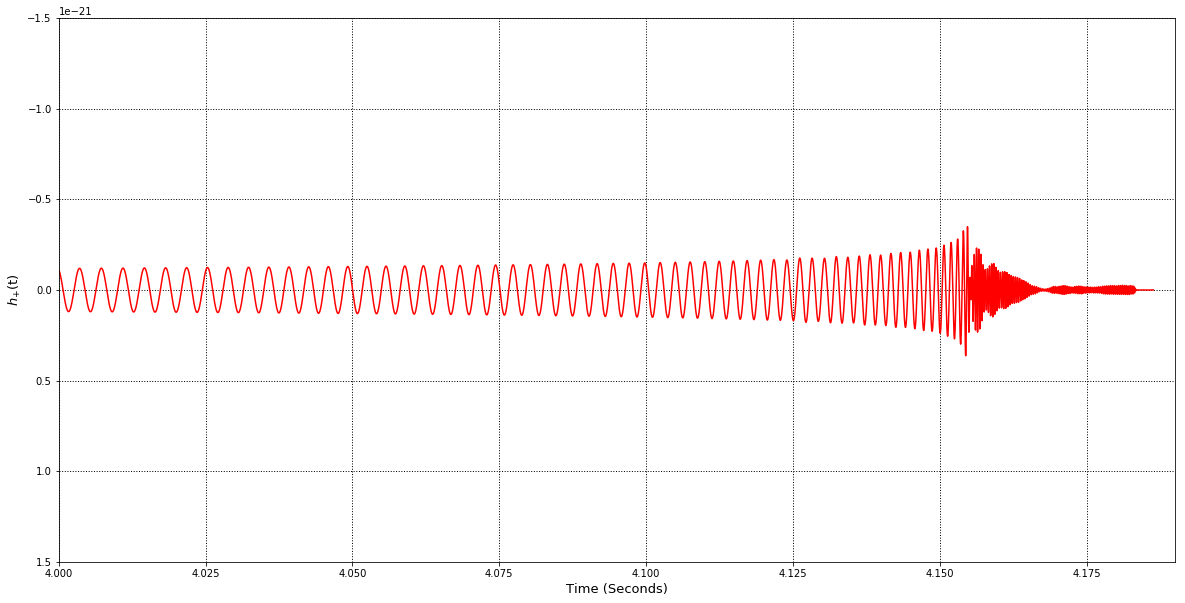

In [23]:
plt.figure(figsize=(20,10))
plt.plot(hybrid[5][0][:],hybrid[5][1][:],color='red')
plt.grid(color='black', linestyle=':', linewidth=1)
plt.xlabel('Time (Seconds)',fontsize=13)
plt.ylabel('$h_{\plus}$(t)',fontsize=13)
plt.ylim([1.5*10**-21,-1.5*10**-21])
plt.xlim([4,4.19])

plt.show()

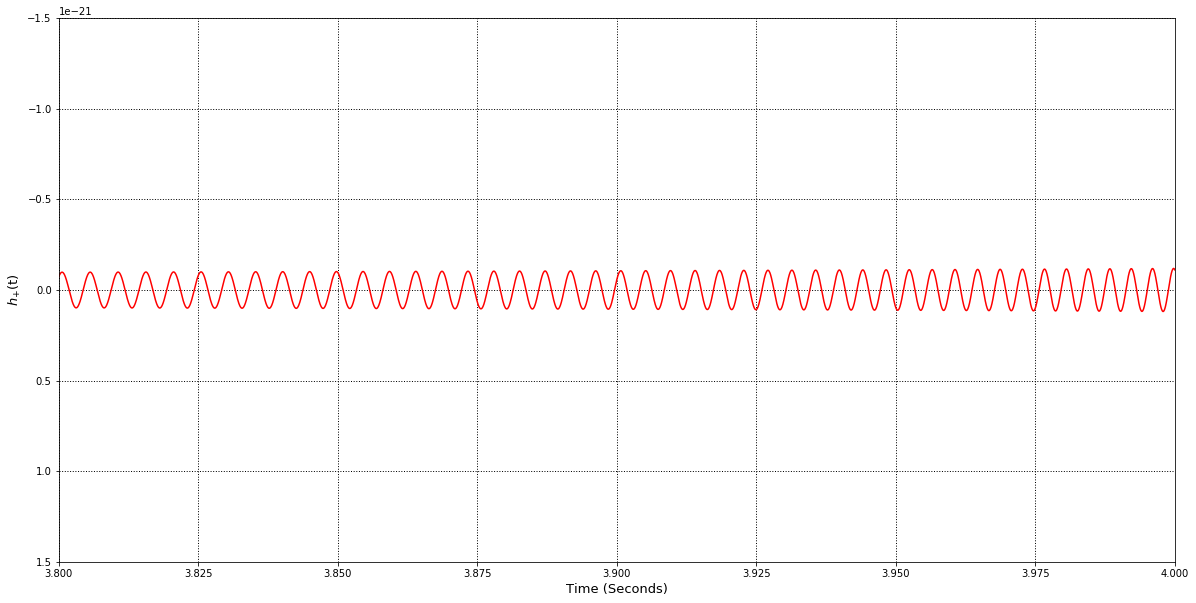

In [25]:
plt.figure(figsize=(20,10))
plt.plot(hybrid[5][0][:w],hybrid[5][1][:w],color='red')
plt.grid(color='black', linestyle=':', linewidth=1)
plt.xlabel('Time (Seconds)',fontsize=13)
plt.ylabel('$h_{\plus}$(t)',fontsize=13)
plt.ylim([1.5*10**-21,-1.5*10**-21])
plt.xlim([3.8,4])
plt.show()

In [ ]:
plt.plot(hybrid[5][0],hybrid[5][2])
plt.xlim([2.8,3.1])
plt.show()

In [ ]:
###Now Save the hybrid waveform. this one should be in the summed spherical harmonic format since Pycbc read in all
###all the (l,m) modes.
name = 'PrelimHybrid_Deitrich_ALF2_TaylorT4.h5'
### below is the default hybrid organization. organized by hybrid type/simulation_name/approximate/...h5
#path_name_data = 'HybridAnnex/'+hybrid_type+'/'+sim_name+'/'+approx+'/'
f_low_M = f_lower_approx * (lal.TWOPI * total_mass_import * lal.MTSUN_SI)
with h5py.File(name+'.h5','w') as fd:
#with h5py.File(path_name_data+sim_hybrid_name+'_'+approx+ '.h5','w') as fd:
    mchirp, eta = pnutils.mass1_mass2_to_mchirp_eta(m1, m2)
    hashtag = hashlib.md5()
    fd.attrs.create('type', 'Hybrid:%s'%type)
    hashtag.update(fd.attrs['type'])
    fd.attrs.create('hashtag', hashtag.digest())
    fd.attrs.create('Read_Group', 'Flynn')
    fd.attrs.create('approx', approx)
    fd.attrs.create('sim_name', sim_name)
    fd.attrs.create('f_lower_at_1MSUN', f_low_M)
    fd.attrs.create('eta', eta)
    fd.attrs.create('spin1x', s1x)
    fd.attrs.create('spin1y', s1y)
    fd.attrs.create('spin1z', s1z)
    fd.attrs.create('spin2x', s2x)
    fd.attrs.create('spin2y', s2y)
    fd.attrs.create('spin2z', s2z)
    fd.attrs.create('LNhatx', LNhatx)
    fd.attrs.create('LNhaty', LNhaty)
    fd.attrs.create('LNhatz', LNhatz)
    fd.attrs.create('nhatx', n_hatx)
    fd.attrs.create('nhaty', n_haty)
    fd.attrs.create('nhatz', n_hatz)
    fd.attrs.create('coa_phase', coa_phase)
    fd.attrs.create('mass1', m1)
    fd.attrs.create('mass2', m2)
    fd.attrs.create('lambda1',lambda_1)
    fd.attrs.create('lambda2',lambda_2)
    fd.attrs.create('PN_fp2', len(h1))
    fd.attrs.create('Num_begin_window_index',0 )
    fd.attrs.create('shift_times',hybrid[6])
    fd.attrs.create('hybridize_freq',hybrid[7])
    gramp = fd.create_group('amp_l2_m2')
    grphase = fd.create_group('phase_l2_m2')
    times = hybrid[5][0]
    hplus = hybrid[5][1]
    hcross = hybrid[5][2]
    massMpc = total_mass*solar_mass_mpc
    hplusMpc  = pycbc.types.TimeSeries(hplus/massMpc, delta_t=delta_t)
    hcrossMpc = pycbc.types.TimeSeries(hcross/massMpc, delta_t=delta_t)
    times_M = times / (lal.MTSUN_SI * total_mass)
    HlmAmp = wfutils.amplitude_from_polarizations(hplusMpc,hcrossMpc).data
    print 'computing spline'
    HlmPhase = wfutils.phase_from_polarizations(hplusMpc, hcrossMpc).data
    sAmph = romspline.ReducedOrderSpline(times_M, HlmAmp,rel=True ,verbose=False)
    sPhaseh = romspline.ReducedOrderSpline(times_M, HlmPhase, rel=True,verbose=False)
    sAmph.write(gramp)
    sPhaseh.write(grphase)
    fd.close()

In [ ]:
###check to show it works
#hybrid_path = '../Simulations/BNS/Haas/Haas_Reformat_rh_CceR2090_l2_m2.h5'
hybrid_path = 'HybridAnnex/BNS/Haas500/TEOBv4/Haas_TEOBv4fp2_3610.h5'
hybrid_read = h5py.File(hybrid_path, 'r')
#for item in hybrid_read.attrs.keys():
    #print item + ":", hybrid_read.attrs[item]
hm1 = hybrid_read.attrs['ADM_mass1']
hm2 = hybrid_read.attrs['ADM_mass2']
hs1z = hybrid_read.attrs['spin1z']
hs1x = hybrid_read.attrs['spin1x']
hs1y = hybrid_read.attrs['spin1y']
hs2z = hybrid_read.attrs['spin2z']
hs2x = hybrid_read.attrs['spin2x']
hs2y = hybrid_read.attrs['spin2y']
hdistance = 1.0
hinclination = 0.0
f_lowh = 80
hhp,hhc = get_td_waveform(approximant='NR_hdf5',numrel_data=hybrid_path,mass1=hm1,
                                                                      mass2=hm2,
                                                                      spin1z=hs1z,spin1x=hs1x,spin1y=hs1y,
                                                                      spin2z=hs2z,spin2x=hs2x,spin2y=hs2y,
                                                                      delta_t=delta_t,distance=hdistance,
                                                                      f_lower=f_lowh,
                                                                      inclination=hinclination)

plt.plot(hhp.sample_times,hhp)
plt.xlim([2.8,3.1])
plt.show()

In [ ]:
plt.plot(hhp.sample_times,np.abs(hhp+1j*hhc))
plt.xlim([41.8,41.92])
plt.show()

In [ ]:
plt.plot(hhp.sample_times,-1*np.unwrap(np.angle(hhp+1j*hhc)))
plt.show()

In [ ]:
#### below is an example of reading in hybrid characterization data created from hybridChars_numerical.py

In [ ]:
B0_char_data = 'HybridAnnex/BNS/B0/TaylorT2/HybridChars.h5'
char_B0_T2 = h5py.File(B0_char_data,'r')

In [ ]:
time_slices = char_B0_T2['time_slices']
match_numfp = char_B0_T2['match_num_fp']
plt.plot(time_slices,match_numfp)
plt.show()

In [ ]:
shift_times = np.array(char_B0_T2['shift_times'])
times_indices = twodimarray_to_2array(shift_times)
time_on_T2 = []
for i in times_indices[1]:
    time_on_T2.append(time_slices[int(i)])
plt.plot(time_on_T2,times_indices[0],'ro',label='T2')
plt.ylabel('Shift Time (Seconds)')
plt.xlabel('Time Slice (Seconds)')
plt.legend()
plt.show()

In [ ]:
freq_slices = np.array(char_B0_T2['freq_slices'])
hybrid_freqs = np.array(char_B0_T2['hybridize_freq'])
freqs_indices = twodimarray_to_2array(hybrid_freqs)
freqs_on_T2 = []
for i in freqs_indices[1]:
    freqs_on_T2.append(freq_slices[int(i)])
plt.plot(freqs_on_T2,freqs_indices[0],'bo',label='T2')
plt.ylabel('Hybridize Frequency (Hz) ')
plt.xlabel('Frequency Slice (Hz)')
plt.legend()
plt.show()